Loading data... 

******************************************************************** 
 ADF Test Statistic
ADF Test Statistic : -1.6809427952378235
p-value : 0.44095709953614237
#Lags Used : 11
Number of Observations : 773
weak evidence against null hypothesis,indicating it is non-stationary 



******************************************************************** 
 Plot Original Series


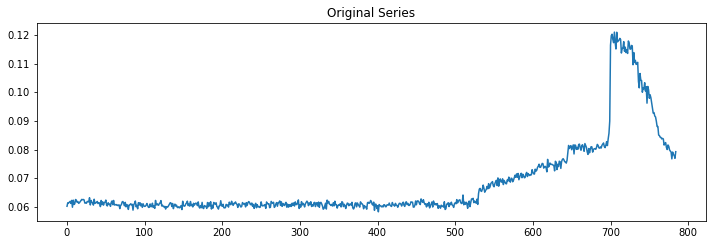


******************************************************************** 
 Plot Partial Autocorrelation


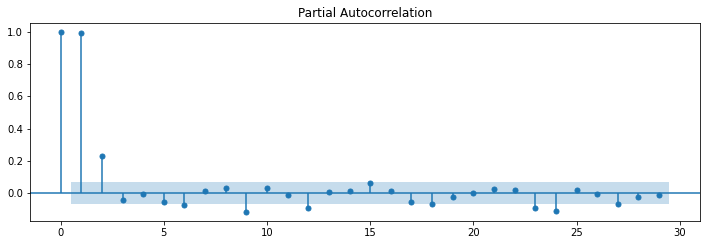


******************************************************************** 
 Plot Autocorrelation


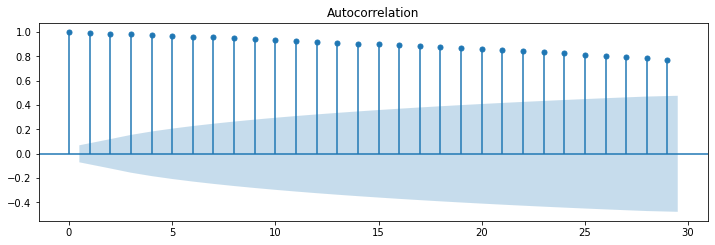

Normal ARIMA(1,0,30)                                                                                      
======================================================= ==================================================
Dependent Variable: Bearing1                            Method: PML                                       
Start Date: 815                                         Unnormalized Log Posterior: 427.7072              
End Date: 981                                           AIC: -789.4143                                    
Number of observations: 167                             BIC: -686.5205                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0322     0.0124     2.5917   0.0096   (0.0079 | 0.0566)        
AR(1)                                

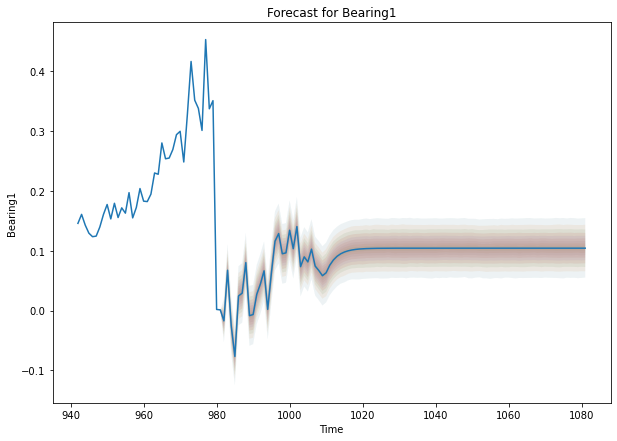

      Bearing1
982  -0.017242
983   0.067444
984  -0.025332
985  -0.076851
986   0.024456
...        ...
1077  0.104372
1078  0.104372
1079  0.104372
1080  0.104372
1081  0.104372

[100 rows x 1 columns]


In [2]:
from time import time
from pandas import read_csv
from termcolor import  colored
from modules import run_arima as ARIMA
from modules import run_lstm as LSTM

ARIMA_config = {
    'test_size':0.2,
    'AR':1,
    'MA':30,
    'target_method':'PML',
    'h':100,
    'pv':40
}

LSTM_config = {
    'test_size':0.2,
    'is_normalized':True,
    'epochs':3,
    'batch_size':50,
    'validation_split':0.05,
    'loss':'mean_squared_error',
    'optimizer':'rmsprop',
    'metrics':['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
}

def exec_time(func, args:list) -> tuple:
    '''
    Function that measures execution time of a given function
    '''
    error = None
    intiTime = time()
    try:
        func(*args)
    except Exception as e:
        error = e
    elapsedTime = round(time()-intiTime, 2)
    if elapsedTime >= 60:
        elapsedTime = str(elapsedTime/60) + 'm'
    else:
        elapsedTime = str(elapsedTime)+'s'
    return elapsedTime, error


def csv_to_df(csv_file:str):
    '''returns numpy array of values from a dataFrame)'''
    print('Loading data... ')
    df = read_csv(csv_file, parse_dates=[0], infer_datetime_format=True)
    return df


def run_arima(file:str, column:str):
    df = csv_to_df(file)
    ARIMA.run(df, column, ARIMA_config)


def run_lstm(file:str, column:str):
    df = csv_to_df(file)
    LSTM.run(df,column,LSTM_config)

def main():
    paths = {
        'vibration':['Averaged_BearingTest_Dataset.csv','Bearing1']
    }
    
    for solution in ['ARIMA','LSTM'][:1]:
        error = None
        if solution == 'ARIMA':
            elapsedTime, error = exec_time(run_arima, args=paths['vibration'])
        elif solution == 'LSTM':
            elapsedTime, error = exec_time(run_lstm, args=paths['vibration'])
        if error != None:
            print("ERROR: ",error)
        print("\n"+solution+" TIME --->", elapsedTime)


# main()

# run_arima('Averaged_BearingTest_Dataset.csv','Bearing1')